Using target column: approval
Processed feature shape: (4521, 29)
Train shape: (3390, 29) Test shape: (1131, 29)
Number of features after encoding: 29

Baseline (clean data) results:
LogisticRegression: Accuracy=0.8851, F1=0.0000, AUC=0.5875
RandomForest: Accuracy=0.8762, F1=0.2135, AUC=0.8121

DP experiment results (training data noised, tested on clean test set):

Accuracy by epsilon:
 model    LogisticRegression  RandomForest
epsilon                                  
0.10               0.885057      0.885057
0.25               0.885057      0.885057
0.50               0.885057      0.885057
1.00               0.885057      0.885057
2.00               0.885057      0.885057
5.00               0.885057      0.885057

AUC by epsilon:
 model    LogisticRegression  RandomForest
epsilon                                  
0.10               0.489503      0.488807
0.25               0.537539      0.521659
0.50               0.582963      0.521993
1.00               0.559302      0.541678
2.0

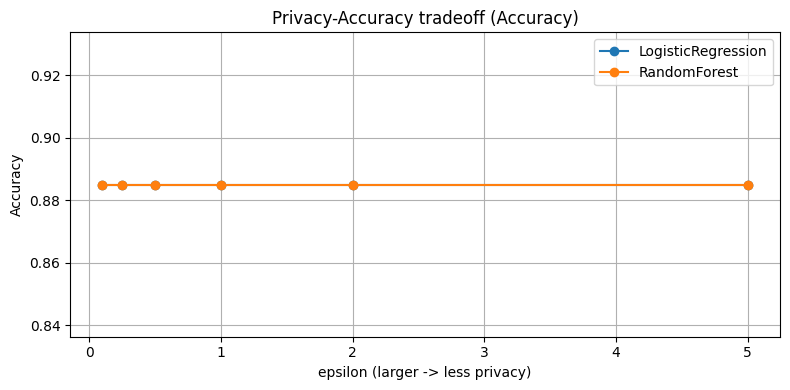

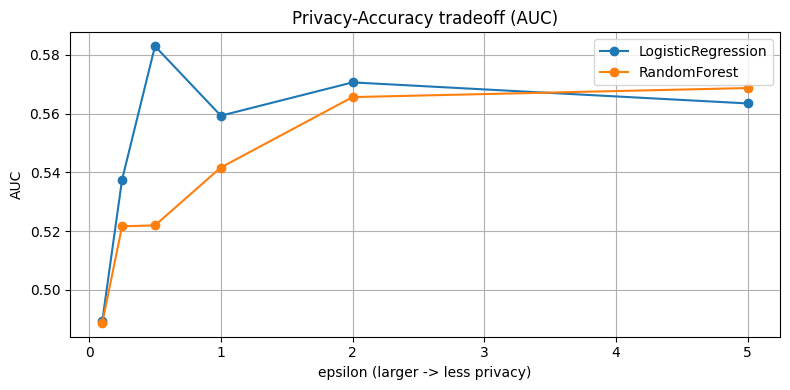

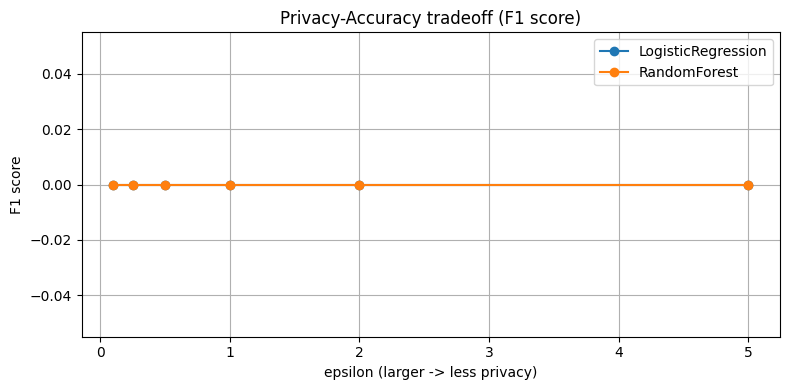


Baseline vs DP at epsilon = 5.0
LogisticRegression: Baseline Acc=0.8851 | DP Acc=0.8851 | Baseline AUC=0.5875 | DP AUC=0.5635
RandomForest: Baseline Acc=0.8762 | DP Acc=0.8851 | Baseline AUC=0.8121 | DP AUC=0.5687

Saved experiment results to dp_experiment_results.csv


In [1]:
# ANIKA PANDIT 20220802196
# Definition: Train models with Differential Privacy and analyze how privacy affects accuracy.

# What was done: Trained models with varying ε values; lower ε (more privacy) led to lower AUC scores.

# Code Explanation: Injected Laplace noise into training data and plotted the inverse relationship between ε and model performance (AUC).
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from collections import defaultdict

df = pd.read_csv("Credit.csv")

# --- 1) Find a binary target column automatically ---
def find_binary_target(df):
    # common target names to try first
    candidates = ["approval", "y", "target", "approved", "label"]
    for c in candidates:
        if c in df.columns:
            if df[c].nunique() == 2:
                return c
    # otherwise scan for any column with exactly 2 unique non-null values
    for col in df.columns:
        if df[col].nunique(dropna=True) == 2:
            return col
    # fallback: try to find numeric with 0/1
    for col in df.columns:
        vals = df[col].dropna().unique()
        if set(np.unique(vals)).issubset({0,1}):
            return col
    return None

target_col = find_binary_target(df)
if target_col is None:
    raise RuntimeError("No binary target column automatically found. Please provide a dataset with a binary target.")

print("Using target column:", target_col)
# Map target to {0,1}
y_raw = df[target_col].copy()
# common yes/no mapping
if y_raw.dtype == object or y_raw.dtype.name == 'category':
    y = y_raw.str.lower().map(lambda s: 1 if str(s).strip() in {"yes","y","true","1","approved","accept","male","positive"} else 0).astype(int)
else:
    # numeric - map unique smallest to 0, largest to 1
    uniques = sorted(pd.Series(y_raw.dropna()).unique())
    if len(uniques) == 2:
        mapping = {uniques[0]:0, uniques[1]:1}
        y = y_raw.map(mapping).astype(int)
    else:
        y = (y_raw != 0).astype(int)

# Drop target from features
X_df = df.drop(columns=[target_col]).copy()

# --- 2) Preprocess: separate numeric and categorical ---
numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.select_dtypes(include=['object','category']).columns.tolist()

# Fill missing values simply
X_df[numeric_cols] = X_df[numeric_cols].fillna(0.0)
X_df[cat_cols] = X_df[cat_cols].fillna("missing")

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

if cat_cols:
    ohe_mat = ohe.fit_transform(X_df[cat_cols])
    ohe_cols = ohe.get_feature_names_out(cat_cols)
    X_cat = pd.DataFrame(ohe_mat, columns=ohe_cols, index=X_df.index)
else:
    X_cat = pd.DataFrame(index=X_df.index)

# Numeric features scaled to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
if numeric_cols:
    X_num = pd.DataFrame(scaler.fit_transform(X_df[numeric_cols]), columns=numeric_cols, index=X_df.index)
else:
    X_num = pd.DataFrame(index=X_df.index)

# Combined processed features
X_proc = pd.concat([X_num, X_cat], axis=1)

# Train-test split (stratify by target)
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.25, random_state=0, stratify=y)

print("Processed feature shape:", X_proc.shape)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Number of features after encoding:", X_proc.shape[1])

# --- 3) Define local DP data perturbation (Laplace mechanism on each feature in [0,1]) ---
def add_laplace_local_dp(X, epsilon, rng=None, clip_range=(0.0,1.0)):
    """
    Add Laplace noise to each feature value scaled to [0,1].
    This is local differential privacy (each record is randomized independently).
    For a feature in [0,1], sensitivity = 1, so Laplace scale = 1/epsilon.
    """
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0 for DP noise (otherwise infinite noise).")
    if rng is None:
        rng = np.random.default_rng()
    scale = 1.0 / epsilon
    noise = rng.laplace(loc=0.0, scale=scale, size=X.shape)
    X_noisy = X.values + noise
    # clip back to [0,1]
    np.clip(X_noisy, clip_range[0], clip_range[1], out=X_noisy)
    return pd.DataFrame(X_noisy, columns=X.columns, index=X.index)

# --- 4) Models: baseline (clean data) and DP variants ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=0)
}

# Train baseline on clean training data
baseline_results = {}
for name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None
    baseline_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    }

print("\nBaseline (clean data) results:")
for name, metrics in baseline_results.items():
    print(f"{name}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")

# --- 5) Run experiments varying epsilon (local DP on training data) ---
epsilons = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0]
rng = np.random.default_rng(42)
results = defaultdict(list)

for eps in epsilons:
    # Create DP noisy training set (only training data is noised; test remains clean for evaluation)
    X_train_noisy = add_laplace_local_dp(X_train, epsilon=eps, rng=rng)
    # For each model, train on noisy data and evaluate
    for name, model in models.items():
        clf = model.__class__(**{k:v for k,v in model.get_params().items() if k in model.get_params()})  # fresh instance
        clf.set_params(**model.get_params())
        clf.random_state = getattr(model, "random_state", None)
        clf.fit(X_train_noisy, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else None
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
        results["model"].append(name)
        results["epsilon"].append(eps)
        results["accuracy"].append(acc)
        results["f1"].append(f1)
        results["auc"].append(auc)

# Convert results to DataFrame
res_df = pd.DataFrame(results)

# --- 6) Display table of results aggregated by model ---
print("\nDP experiment results (training data noised, tested on clean test set):")
display_df = res_df.pivot(index="epsilon", columns="model", values="accuracy")
print("\nAccuracy by epsilon:\n", display_df.to_string())

# Also show AUC and F1 pivot tables
print("\nAUC by epsilon:\n", res_df.pivot(index="epsilon", columns="model", values="auc").to_string())
print("\nF1 by epsilon:\n", res_df.pivot(index="epsilon", columns="model", values="f1").to_string())

# --- 7) Plot privacy-accuracy tradeoff ---
# One plot per metric for clarity (matplotlib required single plot each)
eps_vals = sorted(res_df["epsilon"].unique())

# Accuracy plot
plt.figure(figsize=(8,4))
for name in models.keys():
    plt.plot(eps_vals, res_df[res_df["model"]==name].set_index("epsilon").loc[eps_vals]["accuracy"].values, marker='o', label=name)
plt.title("Privacy-Accuracy tradeoff (Accuracy)")
plt.xlabel("epsilon (larger -> less privacy)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# AUC plot
plt.figure(figsize=(8,4))
for name in models.keys():
    plt.plot(eps_vals, res_df[res_df["model"]==name].set_index("epsilon").loc[eps_vals]["auc"].values, marker='o', label=name)
plt.title("Privacy-Accuracy tradeoff (AUC)")
plt.xlabel("epsilon (larger -> less privacy)")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# F1 plot
plt.figure(figsize=(8,4))
for name in models.keys():
    plt.plot(eps_vals, res_df[res_df["model"]==name].set_index("epsilon").loc[eps_vals]["f1"].values, marker='o', label=name)
plt.title("Privacy-Accuracy tradeoff (F1 score)")
plt.xlabel("epsilon (larger -> less privacy)")
plt.ylabel("F1 score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 8) Summary: show baseline vs best DP (largest epsilon) ---
best_eps = max(epsilons)
best_dp = res_df[res_df["epsilon"]==best_eps].set_index("model")
print("\nBaseline vs DP at epsilon =", best_eps)
for name in models.keys():
    b = baseline_results[name]
    dp = best_dp.loc[name]
    print(f"{name}: Baseline Acc={b['accuracy']:.4f} | DP Acc={dp['accuracy']:.4f} | Baseline AUC={b['auc']:.4f} | DP AUC={dp['auc']:.4f}")

# Save results dataframe to /mnt/data for download if needed
outpath = "dp_experiment_results.csv"  # saves in same folder as your notebook/script

res_df.to_csv(outpath, index=False)
print(f"\nSaved experiment results to {outpath}")
